# Project: Modelling, Simulating and Optimisating  train plans for the HS2 line from London to Birmingham

### Name: Simanta Sarkar
### Student ID: x18201148
### Course: MSc in Data Analytics
### Module: Modelling, Simulation and Optimisation (H9MSO)

# Problem Statement

Simulating and optimising the London-Birmingham section of the high-speed line to decide on number of signalling blocks and trains running per hour.

# The Context

## Train information
The HS2 line connecting London and Birmingham has planned to operate high-speed train with the following features:
*   Acceleration: 0.72m/s**2 (approx same as commuter train)
*   Emmergency deceleration: 2.5m/s**2
*   Optimal deceleration: 0.36m/s**2
*   Max. travelling speed: 83.3m/s
*   Time taken to accelerate to maximum speed is 115.7s travelling 4,820m.
*   At optimal decelaration it takes 231.4s to travel 9,640m.

## Signaling blocks
The railway line consists of sequential signaling blocks.A train enters a block only if there is no other train. The entry singal is green when there is no train in the block and turns red with entry of a train. The signal switches to green post 5 sec exit of the train end.










In [ ]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as stats
import math
import numpy as np
import string

import simpy
import simpy.events as evt

# Data Preparation

## Data Given
The railway line consists of four train stations namely London Euston, London Old Oak Common, Birmingham Interchange and Birmingham Curzon Street. Travel time between the stations are 5min, 31mins and 9mins respectively. Additionally, distance between London Old Oak Common Station and Birmingham Interchange Station is given as 145km.

## Calculation
Total distance required to travel in accelerating to attain maximum velocity and deccelerating to reach a following is (4,820m + 9,640m = 14460m) To calculate the distance between the respective stations two situations are taken into consideration.
1.   Distance more than 14460m between two stations: The train accelerates to reach the maximum velocity. Travels a certain distance at constant velocity. Then deccelerates to reach the following station.
2. Distance less than 14460m between two stations: The train accelerates upto one-third of the run time and starts to deccelerated without attaining the maximum speed.  




In [ ]:
def timeTo( d,A=0.72,D=0.32, maxV=83.3):
    """
    A       constant acceleration, m/s²
    D       constant deceleration, m/s²
    maxV    maximumum velocity, m/s
    d       distance, km
    return  time in seconds required to travel
    """
    tA = maxV/A          # time to accelerate to maxV
    tD = maxV/D          # time to decelerate to 0 from maxV
    dA = (A*tA*tA+D*tD*tD)/2                # distance traveled during acceleration from 0 to maxV and back to 0
    print(tA,tD,dA)
    if (d < dA):                # train never reaches full speed?
        return np.sqrt(2.0*(d/3)/A) + np.sqrt(2.0*(2*d/3)/D)        # time needed to accelerate to 1/3rd point then decelerate to destination
    else:
        return tA+tD + (d-dA)/maxV   # time to accelerate to maxV plus travel at maxV plus decelerate to destination

In [ ]:
timeTo(140481.97916666666,.72,.36, 83.3)/60

115.69444444444444 231.38888888888889 14456.020833333334


31.0

In [ ]:
def disTo(T,A=0.72,D=0.32, maxV=83.3):
    """
    A       constant acceleration, m/s²
    D       constant deceleration, m/s²
    maxV    maximumum velocity, m/s
    d       distance, km
    return  time in seconds required to travel
    """
    tA = maxV/A          # time to accelerate to maxV
    tD = maxV/D          # time to decelerate to 0 from maxV
    t=tA+tD              # total acc + dec
    print(t)
    dA = (A*tA*tA+D*tD*tD)/2                # distance traveled during acceleration from 0 to maxV and back to 0
    if (T < t):                # train never reaches full speed?
        return (A*(T/3)*(T/3) + D*(2*T/3)*(2*T/3))/2        # time needed to accelerate to 1/3rd-way point then decelerate to destination
    else:
        return dA + (T-t)*maxV   # time to accelerate to maxV plus travel at maxV plus decelerate to destination

In [ ]:
disTo(60*31,.72,.36, 83.3)

347.0833333333333


140481.97916666666

# Dataset
The attributes of the datasets are starting point(From), destination(To), distance between the stations and the run time.

In [ ]:
import pandas as pd 
  
# intialise data of lists. 
data = {'From':['London_Euston', 'London_Old_Oak_Common', 'Birmingham_Interchange'], 'To':['London_Old_Oak_Common', 'Birmingham_Interchange', 'Birmingham_Curzon_Street'],'Distance':[10800.0, 145000.0, 30525.979166666668],'Run Time':[300.0, 1914.2379451780712, 540.0]} 
  
# Create DataFrame 
dtt = pd.DataFrame(data) 
  
# Print the output. 
dtt

,From,To,Distance,Run Time
0,London_Euston,London_Old_Oak_Common,10800.000000,300.000000
1,London_Old_Oak_Common,Birmingham_Interchange,145000.000000,1914.237945
2,Birmingham_Interchange,Birmingham_Curzon_Street,30525.979167,540.000000


# Dataset with signaling blocks
A dynamic dataset is generated where the number of signaling blocks are appended with the former dataset. Between London_Euston and London_Old_Oak_Common station one signaling block; between Birmingham_Interchange and Birmingham_Curzon_Street two signaling blocks are given. Number of blocks (upto 14) between London_Old_Oak_Common and Birmingham_Interchange is given as an input to generate the dataset.

In [ ]:
def blocks(num,dt):
    
    numm=num+3
    
    if numm<4:
        return 0
    if numm > 20:
        return 0
    else:
        a1 = ['signal_1']
        a3 = ['signal_'+str(numm-1) , 'signal_'+str(numm)]
        a2 = []
        blks2 = []
        blks3 = [numm+1,numm+2,numm+3]
        for i in range(1,numm - 2):
            a2.append('signal_'+str(i+1))
            blks2.append(i+2)
        blks2 = blks2+[numm]
    for i in range(len(dt)):
        from1=dt.at[i,'From']
        to1=dt.at[i,'To']
        dis1=dt.at[i,'Distance']
        run1=dt.at[i,'Run Time']
        if i == 0:
            dis = [dis1/2]*2
            runn = [run1/2]*2
            data = {'Block': [1,2],'From':[from1]+a1, 'To':a1+[to1],'Distance':dis,'Run Time':runn}
            df = pd.DataFrame(data)
        elif i == 1:
            dis = [dis1/(numm-2)]*(numm-2)
            runn = [run1/(numm-2)]*(numm-2)
            data1 = {'Block': blks2,'From':[from1]+a2, 'To':a2+[to1],'Distance':dis,'Run Time':runn}
            df1 = pd.DataFrame(data1)
            df = df.append(df1)
        elif i == 2:
            dis = [dis1/3]*3
            runn = [run1/3]*3
            data1 = {'Block': blks3,'From':[from1]+a3, 'To':a3+[to1],'Distance':dis,'Run Time':runn}
            df1 = pd.DataFrame(data1)
            df = df.append(df1)
        
    return df.reset_index(drop=True)
  

In [ ]:
dt = blocks(1,dtt)

In [ ]:
dt

,Block,From,To,Distance,Run Time
0,1,London_Euston,signal_1,5400.000000,150.000000
1,2,signal_1,London_Old_Oak_Common,5400.000000,150.000000
2,3,London_Old_Oak_Common,signal_2,72500.000000,957.118973
3,4,signal_2,Birmingham_Interchange,72500.000000,957.118973
4,5,Birmingham_Interchange,signal_3,10175.326389,180.000000
5,6,signal_3,signal_4,10175.326389,180.000000
6,7,signal_4,Birmingham_Curzon_Street,10175.326389,180.000000


## Total Distance


In [ ]:
dt['Distance'].sum()

186325.97916666663

## Dividing the distance equally among the signals


In [ ]:
for i in range(len(dt)):
    dt.at[i, 'Drive Time']=int(timeTo(dt.at[i, 'Distance']))

115.69444444444444 260.3125 15660.689236111111
115.69444444444444 260.3125 15660.689236111111
115.69444444444444 260.3125 15660.689236111111
115.69444444444444 260.3125 15660.689236111111
115.69444444444444 260.3125 15660.689236111111
115.69444444444444 260.3125 15660.689236111111
115.69444444444444 260.3125 15660.689236111111
115.69444444444444 260.3125 15660.689236111111
115.69444444444444 260.3125 15660.689236111111
115.69444444444444 260.3125 15660.689236111111


## Data frame with distributed runtime and drive time

In [ ]:
dt

,Block,From,To,Distance,Run Time,Drive Time
0,1,London_Euston,signal_1,5400.000000,150.000000,220.0
1,2,signal_1,London_Old_Oak_Common,5400.000000,150.000000,220.0
2,3,London_Old_Oak_Common,signal_2,29000.000000,382.847589,536.0
3,4,signal_2,signal_3,29000.000000,382.847589,536.0
4,5,signal_3,signal_4,29000.000000,382.847589,536.0
5,6,signal_4,signal_5,29000.000000,382.847589,536.0
6,7,signal_5,Birmingham_Interchange,29000.000000,382.847589,536.0
7,8,Birmingham_Interchange,signal_6,10175.326389,180.000000,302.0
8,9,signal_6,signal_7,10175.326389,180.000000,302.0
9,10,signal_7,Birmingham_Curzon_Street,10175.326389,180.000000,302.0


## Dwell time of 20 seconds is added for the following stations

In [ ]:
dt['Dwell Time']=0

In [ ]:
stationss = ['London_Euston','London_Old_Oak_Common','Birmingham_Interchange']

In [ ]:
for i in range(len(dt)):
    if dt['From'][i] in stationss:
        dt['Dwell Time'][i]=20
    else:
        dt['Dwell Time'][i]=0

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


## The data frame is printed out below with the Dwell Time column appended to it.

In [ ]:
dt

,Block,From,To,Distance,Run Time,Drive Time,Dwell Time
0,1,London_Euston,signal_1,5400.000000,150.000000,220.0,20
1,2,signal_1,London_Old_Oak_Common,5400.000000,150.000000,220.0,0
2,3,London_Old_Oak_Common,signal_2,29000.000000,382.847589,536.0,20
3,4,signal_2,signal_3,29000.000000,382.847589,536.0,0
4,5,signal_3,signal_4,29000.000000,382.847589,536.0,0
5,6,signal_4,signal_5,29000.000000,382.847589,536.0,0
6,7,signal_5,Birmingham_Interchange,29000.000000,382.847589,536.0,0
7,8,Birmingham_Interchange,signal_6,10175.326389,180.000000,302.0,20
8,9,signal_6,signal_7,10175.326389,180.000000,302.0,0
9,10,signal_7,Birmingham_Curzon_Street,10175.326389,180.000000,302.0,0


In [ ]:
dt['Dwell Time'].mean()

6.0

## The histogram illustrates the dwell time at the signals and stations .

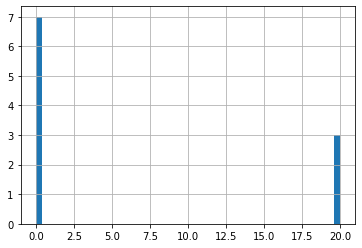

In [ ]:
dt['Dwell Time'].hist(bins=50)

# Utility function
### The time conversion function in the HH:MM:SS format is defined below.

In [ ]:
def formattedSystemTime(t):
    t=int(t)
    return f"{t//3600:02d}:{(t%3600)//60:02d}:{t%60:02d}"
def parseTime(s):
    if isinstance(s, str):
        parts=s.split(':')
        if len(parts)>=2:
            hours=int(parts[0])
            minutes=int(parts[1])
            seconds=0 if len(parts)==2 else int(parts[2])
            return 3600*hours+60*minutes+seconds
    # any wrong formats will be passed through and may cause 
    # an error at a later stage
    return s

# Modelling Infrastructure
The infrastructure consists of stations and signals. These sub-classes are derived from the super class 'NetworkNode' which outlines the blueprint of the classes.

A railway line consists of sequence of signaling blocks and stations. Number of signaling blocks are not constant. 

## Network class

In [ ]:
class NetworkNode:
    
    def __init__(self, env, location):
        self.env=env
        self.location=location
        self.arrTimes=[]
        self.depTimes=[]
        self.dwellTimes=[]
        
        # buffer needed to compute the dwell time as difference of
        # departure time and arrival time
        self.arrTime=0  


    def getArrivalTimes(self):
        return self.arrTimes
    
    def getDepartureTimes(self):
        return self.depTimes
        
    def trace_prefix(self, train):
        return f"{formattedSystemTime(self.env.now):s} " \
               f"[Train_{train.getNo():d}]" 
    
    def arr(self, train):
        self.arrTime=self.env.now
        self.arrTimes+=[self.env.now]
        print(f"{self.trace_prefix(train):s} arr {self.loc():s}")        

    def dep(self, train, dest):
        self.depTimes+=[self.env.now]
        dwellTime=0 if self.arrTime==0 else self.env.now-self.arrTime
        self.dwellTimes+=[dwellTime]
        print(f"{self.trace_prefix(train):s} dep {self.loc():s} for {dest.loc():s}")
                
    def getTrack(self):
        pass
    
    def loc(self):
        pass
    
    def track_name(self):
        pass
    
    def isPeakTime(self):
        now=self.env.now
        return (3600*7<=now and now<=3600*10) or \
               (3600*16<=now and now<=3600*19)

# Station
Here Station class is defined in a way to represent both a signaling block or a station in the railway line with respect to dwell time. For dwell time 0 it represents a signaling block otherwise a station. 

### Weather constraints
Weather condition have a direct impact on the run time and dwell time of the train. Thus, exponential distribution is used to derive drive time of a train.

In [ ]:
class Station(NetworkNode):
    def __init__(self, env, location):
        super().__init__(env, location)
        self.env=env
        self.location=location
        
        self.track=simpy.Resource(env, capacity=1)
        dd=dt[dt['From']==location]
        if dd.shape[0] == 0:
            dd=dt[dt['To']==location]
        
        
        self.drive_time=int(dd.iloc[0].at['Drive Time'])
        self.dwell_time=int(dd.iloc[0].at['Dwell Time'])
            
        self.drive_time_dist= \
                stats.expon(loc=self.drive_time, \
                            scale=self.drive_time*0.2)
        
        
    def driveTime(self):
        return self.drive_time_dist.rvs()
    
    def dwellTime(self):
        return self.dwell_time
        
    def getTrack(self):
        return self.track
    
    def loc(self):
        return self.location
    
    def track_name(self):
        return self.location

In [ ]:
def allStations(env):
    stations=dt['From'].to_list()
    stations+=[dt['To'].to_list()[-1]]
    return [ Station(env, s) for s in stations ]
   

In [ ]:
def allTracks(env, network):
    lines=[]
    stations=[ allStations(env)]
    for station in stations:
        l=Line(env, network,station)
        lines+=[l]
        
    return lines

# Network

The class Network is used to create the simulating environment.

In [ ]:
class Network(object):
    def __init__(self, start, stop, timing):
        self.env=simpy.Environment()
        self.start=parseTime(start)
        self.stop=parseTime(stop)
        self.timing=timing
        self.tracks=allTracks(self.env,self)
        
            
    def process(self):
        for t in self.tracks:
            t.setTiming(self.start, self.stop, self.timing)
            yield self.env.timeout(self.start-self.env.now)
            self.env.process(t.process())
    
    def runSimulation(self, days=1):
        for i in range(days):
            self.env.process(self.process())
        return self.env.run()

# Train
The train class is used to create multiple instances of train running in the simulating environment.

In [ ]:
class Train(object):
    
    def __init__(self, env, i, track,maxPassengers=441): #70 % of 630 
        self.env = env
        self.no=i
        self.track = track
        self.p     = 0
        self.maxP  = maxPassengers
        
    def getNo(self):
        return self.no
    
    
        
    def process(self):
        stations=self.track.getStations()
        here=stations[0]
        here_req=None
        
        yield self.env.timeout(here.dwellTime())
        
        for dest in stations[1:-1]:
                
            # The train is currently in station 'here'. The next station is 'dest'.
            # to depart for dest, the train requests access
            # to the track in the next staion.
                
            dest_req=dest.getTrack().request()
            yield dest_req
                
            # if the train doesn't get immediate access, it continues waiting 
            # in the current station ('here').
            # if the train got access the train departs from 'here'for 'dest'
            
            
                
            here.dep(self, dest)
                
            # Once the train has completely left the station, the train
            # will release the track of station ('here'). 
            # We assume that the train has left the station after 5 secs 
            # the train proceeds to drive to the next station ('dest')
            
            yield self.env.timeout(dest.driveTime())
                    
            dest.arr(self)
                    
            yield self.env.timeout(dest.dwellTime())
            
            yield self.env.timeout(5)
            if here_req!=None:
                here.getTrack().release(here_req)
                    
            here=dest
            here_req=dest_req
                
        # The train is now in the last station and has waited there already long
        # enough for all passengers to disembark. The destination is now the depot.
        depot=stations[-1]
        
        # Assuming that there is always space in the depot,
        # the train leaves for the depot:
        here.dep(self, depot)
                
        # Once the train has completely left the last station ('here'), 
        # the train will release the track of the last station. 
        # We assume that the train has left the station after 10 secs 
                    
        # the train proceeds to drive into the depot
        yield self.env.timeout(depot.driveTime())
                    
        # The train arrives at the depot and "checks in"
        depot.arr(self)
        
        yield self.env.timeout(depot.dwellTime())
        
        yield self.env.timeout(5)#last station dwell time
        if here_req!=None:
            here.getTrack().release(here_req)
        
    def getOff(self, num):
        if self.p >= num:
            self.p -= num
        else:
            num = self.p
            self.p = 0

    def getOn(self, num):
        if (self.maxP is None) or (self.p + num <= self.maxP):
            self.p += num
        else:
            num = self.maxp - self.p
            self.p = self.maxp

# Line
The class Line is used to generate the tracks from the first to last station including the signaling blocks. Here, it is checked for if a signaling block is available for the entry of the tarin.

In [ ]:
class Line(object):
    def __init__(self, env, network, stations):
        self.env=env
        self.network=network
        self.stations=stations
        

    def getNetwork(self):
        return self.network
    
    def getStations(self):
        return self.stations
    
    def setTiming(self, start, stop, timing):
        self.start=start
        self.stop=stop
        self.timing=timing
        
    def process(self):
        yield self.env.timeout(self.start-self.env.now) 
        for i in range(int((self.stop-self.start)/self.timing)):
            t=Train(self.env, i, self,self.network)
            self.env.process(t.process())
            yield self.env.timeout(self.timing)    
            

# Simulation

In [ ]:
network=Network("06:00", "07:00", 300)
network.runSimulation()

06:00:20 [Train_0] dep London_Euston for signal_1
06:04:04 [Train_0] arr signal_1
06:04:09 [Train_0] dep signal_1 for London_Old_Oak_Common
06:15:27 [Train_0] arr London_Old_Oak_Common
06:15:52 [Train_0] dep London_Old_Oak_Common for signal_2
06:15:52 [Train_1] dep London_Euston for signal_1
06:20:21 [Train_1] arr signal_1
06:25:38 [Train_0] arr signal_2
06:25:43 [Train_0] dep signal_2 for signal_3
06:25:43 [Train_1] dep signal_1 for London_Old_Oak_Common
06:35:21 [Train_0] arr signal_3
06:35:26 [Train_0] dep signal_3 for signal_4
06:36:42 [Train_1] arr London_Old_Oak_Common
06:37:07 [Train_1] dep London_Old_Oak_Common for signal_2
06:37:07 [Train_2] dep London_Euston for signal_1
06:41:02 [Train_2] arr signal_1
06:44:39 [Train_0] arr signal_4
06:44:44 [Train_0] dep signal_4 for signal_5
06:47:11 [Train_1] arr signal_2
06:47:16 [Train_1] dep signal_2 for signal_3
06:47:16 [Train_2] dep signal_1 for London_Old_Oak_Common
06:56:30 [Train_1] arr signal_3
06:58:16 [Train_0] arr signal_5
06

# Statistic collection for optimisation
To collect the data the simulation is executed in iterrative manner where the number of signaling blocks varied from 1 to 15. A dynamic dataset is generated at every iteration. 
The peak-time is assumed to be 6:00 to 7:00 in the simulating process. The number of trains running through the 1 hour is calculated.


In [ ]:

no_signals = []
no_trains = []
avg_trv_time  = []

for blks in range(1,15):
    start_time =[]
    train = []
    end_time = []
    #################################
    dt = blocks(blks,dtt)
    
    for i in range(len(dt)):
        dt.at[i, 'Drive Time']=int(timeTo(dt.at[i, 'Distance']))
    dt['Dwell Time']=0
    
    for i in range(len(dt)):
        if dt['From'][i] in stationss:
            dt['Dwell Time'][i]=20
        else:
            dt['Dwell Time'][i]=0
    #################################
    import sys
    old_stdout = sys.stdout
    sys.stdout = open('stdout'+str(blks)+'.txt', 'w')

    network=Network("06:00", "07:00", 300)
    network.runSimulation()

    sys.stdout = old_stdout

    with open('stdout'+str(blks)+'.txt') as f:
        content = f.readlines()
    f.close()
    # you may also want to remove whitespace characters like `\n` at the end of each line
    content = [x.strip() for x in content]

    for line in content:
        ud = line.split()
        n=len(ud) 
        if n==6:
            if parseTime(ud[0])<parseTime("07:00") and ud[2] == 'dep' and ud[3]=='London_Euston':
                start_time.append(ud[0])
                train.append(ud[1])
        elif n==4:
            if ud[2] == 'arr' and ud[3]=='Birmingham_Curzon_Street' and ud[1] in train:
                end_time.append(ud[0])

    df = pd.DataFrame(list(zip(train,start_time,end_time)),columns =['Train','start_time','end_time']) 
    df['travelling_time'] = 0
    for i in range(0,len(df)):
        df['travelling_time'][i] = parseTime(df['end_time'][i])-parseTime(df['start_time'][i])

    no_signals.append(len(dt))
    no_trains.append(len(df))
    avg_trv_time.append(df['travelling_time'].sum()/len(df))

data = pd.DataFrame(list(zip(no_signals,no_trains,avg_trv_time)),columns =['no_Signals','no_train','Average_trv_time']) 

115.69444444444444 260.3125 15660.689236111111
115.69444444444444 260.3125 15660.689236111111
115.69444444444444 260.3125 15660.689236111111
115.69444444444444 260.3125 15660.689236111111
115.69444444444444 260.3125 15660.689236111111
115.69444444444444 260.3125 15660.689236111111
115.69444444444444 260.3125 15660.689236111111
115.69444444444444 260.3125 15660.689236111111
115.69444444444444 260.3125 15660.689236111111
115.69444444444444 260.3125 15660.689236111111
115.69444444444444 260.3125 15660.689236111111
115.69444444444444 260.3125 15660.689236111111
115.69444444444444 260.3125 15660.689236111111
115.69444444444444 260.3125 15660.689236111111
115.69444444444444 260.3125 15660.689236111111
115.69444444444444 260.3125 15660.689236111111
115.69444444444444 260.3125 15660.689236111111
115.69444444444444 260.3125 15660.689236111111
115.69444444444444 260.3125 15660.689236111111
115.69444444444444 260.3125 15660.689236111111
115.69444444444444 260.3125 15660.689236111111
115.694444444

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


115.69444444444444 260.3125 15660.689236111111
115.69444444444444 260.3125 15660.689236111111
115.69444444444444 260.3125 15660.689236111111
115.69444444444444 260.3125 15660.689236111111
115.69444444444444 260.3125 15660.689236111111
115.69444444444444 260.3125 15660.689236111111
115.69444444444444 260.3125 15660.689236111111
115.69444444444444 260.3125 15660.689236111111
115.69444444444444 260.3125 15660.689236111111
115.69444444444444 260.3125 15660.689236111111
115.69444444444444 260.3125 15660.689236111111
115.69444444444444 260.3125 15660.689236111111
115.69444444444444 260.3125 15660.689236111111
115.69444444444444 260.3125 15660.689236111111
115.69444444444444 260.3125 15660.689236111111
115.69444444444444 260.3125 15660.689236111111
115.69444444444444 260.3125 15660.689236111111
115.69444444444444 260.3125 15660.689236111111
115.69444444444444 260.3125 15660.689236111111
115.69444444444444 260.3125 15660.689236111111
115.69444444444444 260.3125 15660.689236111111
115.694444444

# Simulating Blocks
For the simulation problem the train network is divided into k signaling block where k lies between 1 to 15. Additionally, number of trains per hour and average travel time is calculated.

Here, it is to mention that for one signaling block between London Old Oak Common and Birmingham Interchange the total number of signaling block in the line sum ups to seven as there is a fixed number of one and two signaling blocks between first two and last two stations respectively. 

In [ ]:
data

,no_Signals,no_train,Average_trv_time
0,7,2,4746.500000
1,8,3,4805.666667
2,9,3,4936.666667
3,10,4,5253.000000
4,11,4,5537.000000
5,12,4,5718.750000
6,13,4,6062.500000
7,14,4,6035.000000
8,15,5,6481.200000
9,16,5,7035.000000


# Optimization function
Linear regression is used on the above generated dataset to obtain the objective optimization function.

In [ ]:
import statsmodels.api as sm

X = data[['no_Signals','no_train']] 
Y = data['Average_trv_time']

X = sm.add_constant(X) 

model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:       Average_trv_time   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     318.4
Date:                Sun, 10 May 2020   Prob (F-statistic):           1.84e-10
Time:                        22:17:45   Log-Likelihood:                -87.480
No. Observations:                  14   AIC:                             181.0
Df Residuals:                      11   BIC:                             182.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2878.0914    188.761     15.247      0.0

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  "anyway, n=%i" % int(n))


## The derived objective function from the linear regression

travel_time = 2878.0914 + 227.1258*(no_Signals)+44.0488*(no_train)

## Optimising average Travel-time

In [ ]:
import pulp

In [ ]:
prob = pulp.LpProblem("Average time",pulp.LpMinimize)

C:\ProgramData\Anaconda3\lib\site-packages\pulp\pulp.py:1114: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


In [ ]:
x_no_train = pulp.LpVariable('no_train', lowBound=2,upBound=5, cat=pulp.LpInteger)
y_no_Signals = pulp.LpVariable('no_Signals', lowBound=7,upBound=20, cat=pulp.LpInteger)

In [ ]:
prob +=2878.0914 + 44.0488* x_no_train + 227.1258* y_no_Signals, "Z"

In [ ]:
prob +=2878.0914 + 44.0488* x_no_train + 227.1258* y_no_Signals >= 4746

In [ ]:
prob +=2878.0914 + 44.0488* x_no_train + 227.1258* y_no_Signals <= 7589

## The optimization constraints are formulated below

In [ ]:
prob

Average_time:
MINIMIZE
227.1258*no_Signals + 44.0488*no_train + 2878.0914
SUBJECT TO
_C1: 227.1258 no_Signals + 44.0488 no_train >= 1867.9086

_C2: 227.1258 no_Signals + 44.0488 no_train <= 4710.9086

VARIABLES
7 <= no_Signals <= 20 Integer
2 <= no_train <= 5 Integer

In [ ]:
prob.solve()

1

In [ ]:
prob.solve()
pulp.LpStatus[prob.status]

'Optimal'

In [ ]:
for variable in prob.variables():
    print (variable.name, variable.varValue)

no_Signals 8.0
no_train 2.0


### The optimized minimum travel time

In [ ]:
pulp.value(prob.objective)

4783.1954